# Tutorial for PynPoint

In this tutorial we will process a [SPHERE/ZIMPOL](https://www.eso.org/sci/facilities/paranal/instruments/sphere/inst.html) H-alpha dataset of [HD 142527](https://ui.adsabs.harvard.edu/abs/2019A%26A...622A.156C/abstract), for which we make used of already preprocessed images. This example highlights some of the functionalities of PynPoint but a complete overview of all pipeline modules is [available in the documentation](https://pynpoint.readthedocs.io/en/latest/overview.html).

## Getting started

We start by importing the require Python modules. 

In [1]:
import tarfile
import configparser
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

And also the `Pypeline` and the pipeline modules that we need.

In [2]:
from pynpoint import Pypeline, FitsReadingModule, ParangReadingModule, \
                     StarExtractionModule, BadPixelSigmaFilterModule, \
                     StarAlignmentModule, FitCenterModule, ShiftImagesModule, \
                     PSFpreparationModule, PcaPsfSubtractionModule, \
                     FalsePositiveModule, SimplexMinimizationModule, \
                     FakePlanetModule, ContrastCurveModule, \
                     FitsWritingModule, TextWritingModule

Next, we will download the preprocessed images and the parallactic angles.

In [3]:
urllib.request.urlretrieve('https://people.phys.ethz.ch/~stolkert/pynpoint/hd142527_zimpol_h-alpha.tgz',
                           'hd142527_zimpol_h-alpha.tgz')

('hd142527_zimpol_h-alpha.tgz', <http.client.HTTPMessage at 0x13c335278>)

And we will unpack the data in a folder called `input`.

In [4]:
tar = tarfile.open('hd142527_zimpol_h-alpha.tgz')
tar.extractall(path='input')

## Creating the configuration file

PynPoint requires a configuration file which contains the global settings and the FITS header keywords that have to be imported. The text file should be called `PynPoint_config.ini` and several examples are [available here](https://pynpoint.readthedocs.io/en/latest/configuration.html). In this case, we don't need any of the header data.

In [5]:
config = configparser.ConfigParser()
config.add_section('header')
config.add_section('settings')
config['settings']['PIXSCALE'] = '0.0036'
config['settings']['MEMORY'] = '100'
config['settings']['CPU'] = '1'

with open('PynPoint_config.ini', 'w') as configfile:
    config.write(configfile)

## Initiating the Pypeline

We can now initiate the `Pypeline` by setting the working, input, and output folders.

In [6]:
# create an instance of the Pypeline

pipeline = Pypeline(working_place_in='./',
                    input_place_in='input/',
                    output_place_in='./')

PynPoint v0.8.3

Database: ./PynPoint_database.hdf5
Configuration: ./PynPoint_config.ini

Number of CPUs: 1
Number of threads: not set


## Importing the images and parallactic angles

In [7]:
# import the preprocessed ZIMPOL data

module = FitsReadingModule(name_in='read',
                           input_dir=None,
                           image_tag='zimpol',
                           overwrite=True,
                           check=False,
                           filenames=None,
                           ifs_data=False)

pipeline.add_module(module)
pipeline.run_module('read')


-----------------
FitsReadingModule
-----------------

Module name: read
Reading FITS files... [DONE]                      
Output ports: zimpol (70, 1024, 1024), fits_header/cal_OBS091_0235_cam2.fits (868,), fits_header/cal_OBS091_0237_cam2.fits (868,), fits_header/cal_OBS091_0239_cam2.fits (868,), fits_header/cal_OBS091_0241_cam2.fits (868,), fits_header/cal_OBS091_0243_cam2.fits (868,), fits_header/cal_OBS091_0245_cam2.fits (868,), fits_header/cal_OBS091_0247_cam2.fits (868,)


In [8]:
pipeline.get_shape('zimpol')

(70, 1024, 1024)

In [9]:
# import the parallactic angles

module = ParangReadingModule(name_in='parang',
                             data_tag='zimpol',
                             file_name='parang.dat',
                             input_dir=None,
                             overwrite=True)

pipeline.add_module(module)
pipeline.run_module('parang')


-------------------
ParangReadingModule
-------------------

Module name: parang
Reading parallactic angles... [DONE]
Number of angles: 70
Rotation range: -14.31 - 34.36 deg
Output port: zimpol (70, 1024, 1024)


In [10]:
parang = pipeline.get_attribute('zimpol', 'PARANG', static=False)
print(parang)

[-14.3082  -13.9496  -13.5902  -13.23    -12.8691  -12.5074  -12.145
 -11.782   -11.4182  -11.0538   -6.43366  -6.0622   -5.69037  -5.3182
  -4.9457   -4.57291  -4.19983  -3.8265   -3.45294  -3.07917   1.61837
   1.99275   2.36701   2.74112   3.11507   3.48882   3.86237   4.23567
   4.60872   4.98149   9.6373   10.0041   10.3703   10.736    11.101
  11.4653   11.829    12.192    12.5543   12.9158   17.3717   17.7218
  18.0711   18.4193   18.7666   19.1129   19.4581   19.8024   20.1456
  20.4878   24.9167   25.243    25.568    25.8919   26.2145   26.536
  26.8563   27.1753   27.4931   27.8097   31.7057   32.0052   32.3035
  32.6005   32.8962   33.1906   33.4838   33.7757   34.0663   34.3556 ]


## Bad pixel correction

In [11]:
# correct bad pixels

module = BadPixelSigmaFilterModule(name_in='badpixel',
                                   image_in_tag='crop',
                                   image_out_tag='bad',
                                   map_out_tag=None,
                                   box=9,
                                   sigma=5.,
                                   iterate=3)

pipeline.add_module(module)
pipeline.run_module('badpixel')


-------------------------
BadPixelSigmaFilterModule
-------------------------

Module name: badpixel
Input port: crop (70, 57, 57)
Deleting data and attributes: bad
Bad pixel sigma filter... [DONE]                      
Output port: bad (70, 57, 57)


## Image centering

In [12]:
# extract the stellar position with pixel precision

module = StarExtractionModule(name_in='extract',
                              image_in_tag='zimpol',
                              image_out_tag='crop',
                              index_out_tag=None,
                              image_size=0.2,
                              fwhm_star=0.03,
                              position=(476, 436, 0.1))

pipeline.add_module(module)
pipeline.run_module('extract')


--------------------
StarExtractionModule
--------------------

Module name: extract
Input port: zimpol (70, 1024, 1024)
Deleting data and attributes: crop
Extracting stellar position... [DONE]                      
Output port: crop (70, 57, 57)


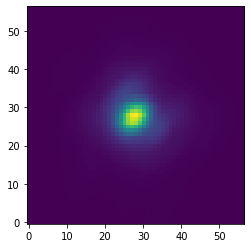

In [13]:
data = pipeline.get_data('crop')
plt.imshow(data[0, ], origin='lower')

In [14]:
# relative alignment of the images

module = StarAlignmentModule(name_in='align',
                             image_in_tag='bad',
                             ref_image_in_tag=None,
                             image_out_tag='aligned',
                             interpolation='spline',
                             accuracy=10,
                             resize=None,
                             num_references=10,
                             subframe=0.1)

pipeline.add_module(module)
pipeline.run_module('align')


-------------------
StarAlignmentModule
-------------------

Module name: align
Input port: bad (70, 57, 57)
Deleting data and attributes: aligned
Aligning images... [DONE]                      
Output port: aligned (70, 57, 57)


In [15]:
# fit the PSF with a 2D Moffat function

module = FitCenterModule(name_in='center',
                         image_in_tag='aligned',
                         fit_out_tag='fit',
                         mask_out_tag=None,
                         method='mean',
                         radius=0.1,
                         sign='positive',
                         model='moffat',
                         filter_size=None,
                         guess=(0., 0., 10., 10., 10000., 0., 0., 1.))

pipeline.add_module(module)
pipeline.run_module('center')


---------------
FitCenterModule
---------------

Module name: center
Input port: aligned (70, 57, 57)
Deleting data and attributes: fit
Fitting the stellar PSF... [DONE]
Output port: fit (70, 16)


In [16]:
# center the images with subpixel precision

module = ShiftImagesModule(name_in='shift',
                           image_in_tag='aligned',
                           image_out_tag='centered',
                           shift_xy='fit',
                           interpolation='spline')

pipeline.add_module(module)
pipeline.run_module('shift')


-----------------
ShiftImagesModule
-----------------

Module name: shift
Input ports: aligned (70, 57, 57), fit (70, 16)
Deleting data and attributes: centered
Shifting the images... [DONE]                      
Output port: centered (70, 57, 57)


(17.0, 40.0)

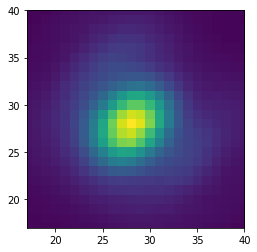

In [17]:
data = pipeline.get_data('centered')
plt.imshow(data[0, ], origin='lower')
plt.xlim(17, 40)
plt.ylim(17, 40)

## Adding a mask

In [18]:
# mask the inner and outer regions before the PSF subtraction

module = PSFpreparationModule(name_in='prep1',
                              image_in_tag='centered',
                              image_out_tag='prep',
                              mask_out_tag=None,
                              norm=False,
                              cent_size=0.02,
                              edge_size=0.2)

pipeline.add_module(module)
pipeline.run_module('prep1')


--------------------
PSFpreparationModule
--------------------

Module name: prep1
Input port: centered (70, 57, 57)
Deleting data and attributes: prep
Preparing images for PSF subtraction... [DONE]                      
Output port: prep (70, 57, 57)


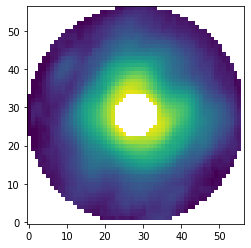

In [19]:
data = pipeline.get_data('prep')
max_flux = np.amax(data[0, ])
plt.imshow(data[0, ], origin='lower', norm=LogNorm(vmin=0.01*max_flux, vmax=max_flux))

In [20]:
# create a PSF template for the flux calibration and detection limits

module = PSFpreparationModule(name_in='prep2',
                              image_in_tag='centered',
                              image_out_tag='psf',
                              mask_out_tag=None,
                              norm=False,
                              cent_size=None,
                              edge_size=0.07)

pipeline.add_module(module)
pipeline.run_module('prep2')


--------------------
PSFpreparationModule
--------------------

Module name: prep2
Input port: centered (70, 57, 57)
Deleting data and attributes: psf
Preparing images for PSF subtraction... [DONE]                      
Output port: psf (70, 57, 57)


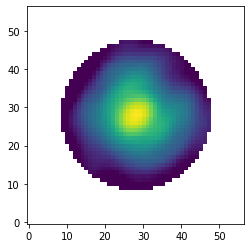

In [21]:
data = pipeline.get_data('psf')
max_flux = np.amax(data[0, ])
plt.imshow(data[0, ], origin='lower', norm=LogNorm(vmin=0.01*max_flux, vmax=max_flux))

## PSF subtraction

In [22]:
# PSF subtraction with full-frame PCA

module = PcaPsfSubtractionModule(name_in='pca',
                                 images_in_tag='prep',
                                 reference_in_tag='prep',
                                 res_mean_tag='pca_mean',
                                 res_median_tag='pca_median',
                                 basis_out_tag='pca_basis',
                                 pca_numbers=range(1, 31),
                                 extra_rot=-133.,
                                 subtract_mean=True)

pipeline.add_module(module)
pipeline.run_module('pca')


-----------------------
PcaPsfSubtractionModule
-----------------------

Module name: pca
Input port: prep (70, 57, 57)
Deleting data and attributes: pca_mean
Deleting data and attributes: pca_median
Deleting data and attributes: pca_basis
Constructing PSF model... [DONE]
Creating residuals... [DONE]                      
Output ports: pca_mean (30, 57, 57), pca_median (30, 57, 57), pca_basis (30, 57, 57)


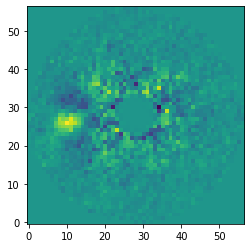

In [23]:
data = pipeline.get_data('pca_median')
plt.imshow(data[14, ], origin='lower')

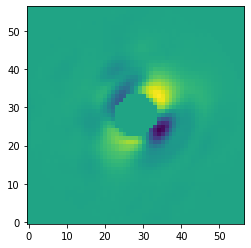

In [24]:
data = pipeline.get_data('pca_basis')
plt.imshow(data[1, ], origin='lower')

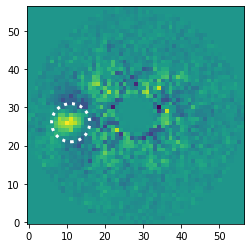

In [25]:
data = pipeline.get_data('pca_median')

fig, ax = plt.subplots()

ax.imshow(data[14, ], origin='lower')

aperture = Circle((11, 26), radius=5, fill=False, ls=':', lw=3., color='white')
ax.add_artist(aperture)

## Signal-to-noise

In [26]:
# compute the S/N and FPF as function of principal components

module = FalsePositiveModule(name_in='snr',
                             image_in_tag='pca_median',
                             snr_out_tag='snr',
                             position=(11., 26.),
                             aperture=5.*0.0036,
                             ignore=True,
                             optimize=False)

pipeline.add_module(module)
pipeline.run_module('snr')


-------------------
FalsePositiveModule
-------------------

Module name: snr
Input port: pca_median (30, 57, 57)
Deleting data and attributes: snr
Calculating S/N and FPF... [DONE]                      
Output port: snr (30, 6)


Text(0, 0.5, 'Signal-to-noise ratio')

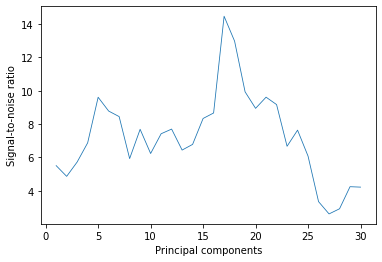

In [27]:
data = pipeline.get_data('snr')
plt.plot(range(1, 31), data[:, 4])
plt.xlabel('Principal components')
plt.ylabel('Signal-to-noise ratio')

## Contrast and position

In [28]:
# determine the relative photometry and astrometry of the companion

module = SimplexMinimizationModule(name_in='simplex',
                                   image_in_tag='centered',
                                   psf_in_tag='psf',
                                   res_out_tag='simplex',
                                   flux_position_tag='fluxpos',
                                   position=(11, 26),
                                   magnitude=6.,
                                   psf_scaling=-1.,
                                   merit='gaussian',
                                   aperture=10.*0.0036,
                                   sigma=0.,
                                   tolerance=0.01,
                                   pca_number=range(1, 11),
                                   cent_size=0.02,
                                   edge_size=0.2,
                                   extra_rot=-133.,
                                   residuals='median',
                                   reference_in_tag=None,
                                   offset=None)

pipeline.add_module(module)
pipeline.run_module('simplex')


-------------------------
SimplexMinimizationModule
-------------------------

Module name: simplex
Input ports: centered (70, 57, 57), psf (70, 57, 57)
Deleting data and attributes: simplex001
Deleting data and attributes: fluxpos001
Deleting data and attributes: simplex002
Deleting data and attributes: fluxpos002
Deleting data and attributes: simplex003
Deleting data and attributes: fluxpos003
Deleting data and attributes: simplex004
Deleting data and attributes: fluxpos004
Deleting data and attributes: simplex005
Deleting data and attributes: fluxpos005
Deleting data and attributes: simplex006
Deleting data and attributes: fluxpos006
Deleting data and attributes: simplex007
Deleting data and attributes: fluxpos007
Deleting data and attributes: simplex008
Deleting data and attributes: fluxpos008
Deleting data and attributes: simplex009
Deleting data and attributes: fluxpos009
Deleting data and attributes: simplex010
Deleting data and attributes: fluxpos010
Simplex minimization... 10

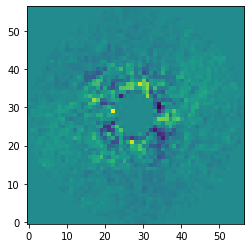

In [29]:
data = pipeline.get_data('simplex010')
plt.imshow(data[-1, ], origin='lower')

Text(0, 0.5, 'Contrast (mag)')

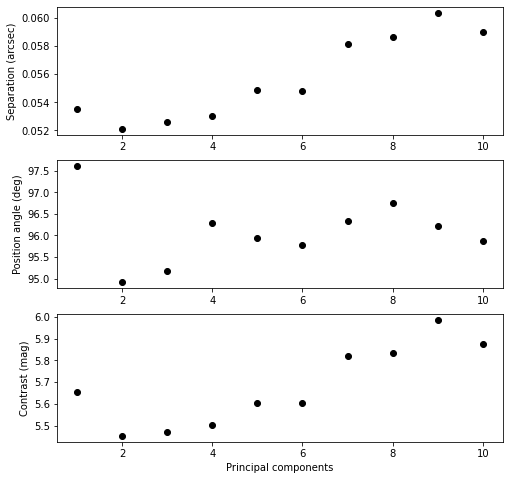

In [30]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

for i in range(1, 11):
    data = pipeline.get_data(f'fluxpos{i:03d}')
    ax1.scatter(i, data[-1, 2], color='black')
    ax2.scatter(i, data[-1, 3], color='black')
    ax3.scatter(i, data[-1, 4], color='black')

ax3.set_xlabel('Principal components')
ax1.set_ylabel('Separation (arcsec)')
ax2.set_ylabel('Position angle (deg)')
ax3.set_ylabel('Contrast (mag)')

## Detection limits

In [31]:
# remove the companion from the dataset

module = FakePlanetModule(position=(0.061, 97.3-133.),
                          magnitude=6.1,
                          psf_scaling=-1.,
                          interpolation='spline',
                          name_in='fake',
                          image_in_tag='centered',
                          psf_in_tag='psf',
                          image_out_tag='removed')

pipeline.add_module(module)
pipeline.run_module('fake')


----------------
FakePlanetModule
----------------

Module name: fake
Input ports: centered (70, 57, 57), psf (70, 57, 57)
Deleting data and attributes: removed
Injecting artificial planets... [DONE]                      
Output port: removed (70, 57, 57)


In [32]:
# estimate detection limits

module = ContrastCurveModule(name_in='limits',
                             image_in_tag='removed',
                             psf_in_tag='psf',
                             contrast_out_tag='limits',
                             separation=(0.05, 5., 0.01),
                             angle=(0., 360., 60.),
                             threshold=('sigma', 5.),
                             psf_scaling=1.,
                             aperture=0.02,
                             pca_number=10,
                             cent_size=0.02,
                             edge_size=2.,
                             extra_rot=-133.,
                             residuals='median')

pipeline.add_module(module)
pipeline.run_module('limits')


-------------------
ContrastCurveModule
-------------------

Module name: limits
Input ports: removed (70, 57, 57), psf (70, 57, 57)
Deleting data and attributes: limits
Calculating detection limits... [DONE]                
Output port: limits (4, 4)


In [33]:
# write the centered images to a FITS file

module = FitsWritingModule(name_in='write1',
                           file_name='centered.fits',
                           output_dir=None,
                           data_tag='centered',
                           data_range=None)

pipeline.add_module(module)
pipeline.run_module('write1')


-----------------
FitsWritingModule
-----------------

Module name: write1
Input port: centered (70, 57, 57)
Writing FITS file... [DONE]


In [34]:
# write the median-combined residuals to a FITS file

module = FitsWritingModule(name_in='write2',
                           file_name='pca_median.fits',
                           output_dir=None,
                           data_tag='pca_median',
                           data_range=None)

pipeline.add_module(module)
pipeline.run_module('write2')


-----------------
FitsWritingModule
-----------------

Module name: write2
Input port: pca_median (30, 57, 57)
Writing FITS file... [DONE]


In [35]:
# write the minimization results of the PSF subtraction to a FITS file

module = FitsWritingModule(name_in='write3',
                           file_name='simplex.fits',
                           output_dir=None,
                           data_tag='simplex',
                           data_range=None)

pipeline.add_module(module)
pipeline.run_module('write3')


-----------------
FitsWritingModule
-----------------

Module name: write3
Input port: simplex (61, 57, 57)
Writing FITS file... [DONE]


In [36]:
# write the detection limits to a text file

module = TextWritingModule(name_in='write4',
                           file_name='limits.dat',
                           output_dir=None,
                           data_tag='limits',
                           header='Separation [arcsec] - Contrast [mag] - Variance [mag] - FPF')

pipeline.add_module(module)
pipeline.run_module('write4')


-----------------
TextWritingModule
-----------------

Module name: write4
Input port: limits (4, 4)
Writing text file... [DONE]
